# County-level Covid-19 Analysis for United States

This notebook utilizes data kindly made available by the New York Times at https://github.com/nytimes/covid-19-data and used for their U.S. tracking page at https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.  It provides a temporal perspective that complements their excellent geospatial presentation.  The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,
a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/Counties-US-covid19-nytimes.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/Counties-US-covid19.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=Counties-US-covid19.ipynb)
  
## Quick links to sections

* [Select state to study at county level](#selectState)
* [Cases by county](#sectionCases)
* [Deaths by county](#sectionDeaths)
* [Growth trends by county](#sectionGrowth)
* [Projection of cases in one county](#sectionProj)
* [Projection of deaths in one county](#sectionProjDeath)

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [15]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [16]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%Y-%m-%d"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)


def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    vals = [x for x in trend.take[-window:]['rate'] if np.isfinite(x)]
    return scipy.stats.gmean(vals)

def project_trend(trend, num_days, rate=None):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

def cases_since(cases, threshold=100, width=6, height=6):
    _, axis = plots.subplots(figsize=(width, height))
    for region in cases.categories :
        ctbl = cases.extract(region)
        since = ctbl.where(ctbl[region] >= threshold)
        ndays = since.num_rows
        vals = since[region]
        axis.plot(vals)
        axis.text(ndays-1, vals[-1], region)

In [17]:
def prior_to(self, prev, time_end=None):
    """Return TimeTable of prev rows prior to time_end, defaults to last."""
    if not time_end :
        time_end = self.last(self.time_column)
    elif isinstance(time_end, int):
        time_end = inc_day(self.last(self.time_column), -time_end)
    return self.between(inc_day(time_end, -prev), time_end)

def make_pname(root, prev):
    return root + "-" + str(prev)

def proj_timeseries(ts, region, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    return project_trend(ts.extract(region).trend(), dist).select(['date', region, 'new'])

def proj2_timeseries(ts, region, prev=2, dist=14, end=None,):
    if not end:
        end = ts['date'][-1]
    proj  = project_trend(prior_to(ts.extract(region), 14+prev ).trend(), dist).select(['date', region, 'new'])
    proj1 = project_trend(prior_to(ts.extract(region), 14, prev).trend(), dist+prev).select(['date', region, 'new'])
    proj1.relabel(region, make_pname(region, prev))
    proj1.relabel('new',  make_pname('new', prev))
    combined = TimeTable.from_table(proj.join('date', proj1), time_col = 'date')
    return combined

def proj(ts, region, prev=7, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    proj = proj_timeseries(ts, region, dist, end)
    prior_to(proj, dist).show()
    prior_to(proj.select(['date', region, 'new']), prev+dist).plot('date', width = 7)
    plots.plot([end, end], [0, ts[region][-1]])
    _ = plots.xticks(rotation=90)
    
def proj2(ts, region, prev=2, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    pend = inc_day(end, -prev)
    combined = proj2_timeseries(ts, region, prev, dist, end)
    combined.oplot(height=6, width=8)
    plots.plot([end, end], [0, combined[region][-1]])
    plots.plot([pend, pend], [0, combined[make_pname(region, prev)][-1]])
    _ = plots.xticks(rotation=90)
    
def get_rates(ts):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if 'rate' in x])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

In [18]:
#URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

countyURL = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

In [19]:
raw_counties = Table.read_table(countyURL)

In [20]:
states = list(np.unique(raw_counties['state']))
len(states)

55

In [21]:
# Number of distinct counties
len(list(np.unique(raw_counties['county'])))

1582

<a id='selectState'></a>
## Select state to examine at county level

Choose a state and run all cells below.

In [22]:
w = widgets.Dropdown(
    options = states,
    value ='California',
    # rows=10,
    description='State:',
    disabled=False
)
w

Dropdown(description='State:', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Co…

In [23]:
state = w.value

In [24]:
raw_state = raw_counties.where('state', state)
counties = list(np.unique(raw_state['county']))
cases = TimeTable.from_table(raw_state.pivot('county', 'date', 'cases', sum), time_col = 'date', 
                             time_less_fun=less_day)
deaths = TimeTable.from_table(raw_state.pivot('county', 'date', 'deaths', sum), time_col = 'date',
                             time_less_fun=less_day)

Current Cases 21366


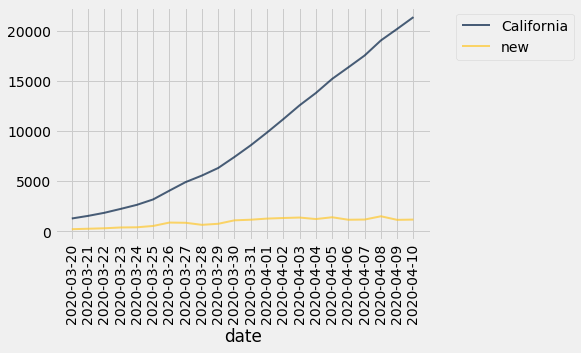

In [25]:
state_cases = cases.select(cases.time_column)
state_cases[state] = cases.sum_cols()
print('Current Cases', state_cases[state][-1])
state_case_trend = state_cases.trend()
prior_to(state_case_trend.extract([state, 'new']), 21).oplot()
_ = plots.xticks(rotation=90)

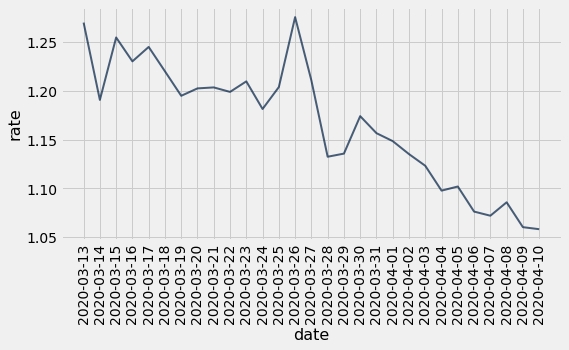

In [26]:
prior_to(state_case_trend.extract(['rate']), 28).oplot(width=8)
_ = plots.xticks(rotation=90)

<a id=sectionCases></a>
## Cases to date by county

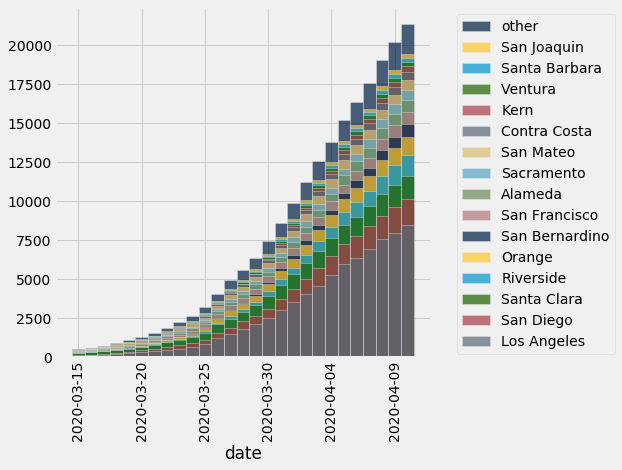

In [27]:
# Total cases broken down by county
cases.after("2020-03-15").stackbar(15, height=6)
_ = plots.xticks(rotation=90)

Cases county-by-county over the past two weeks

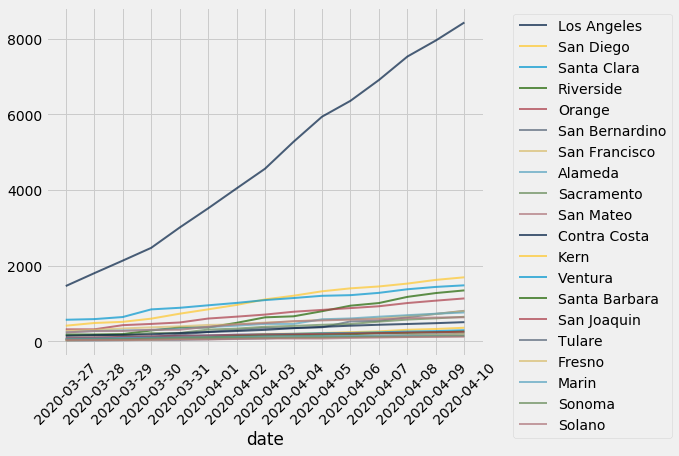

In [28]:
prior_to(cases.top(20), 14).plot('date', width=7, height=6)
_ = plots.xticks(rotation=45)

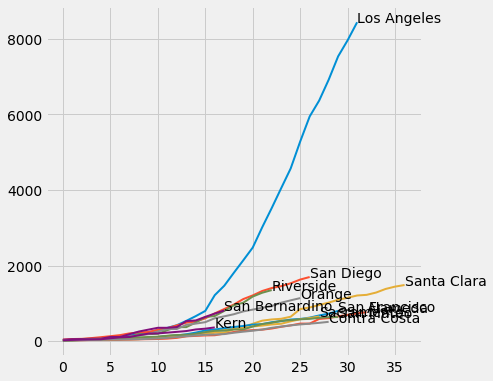

In [29]:
def cases_since(cases, threshold=100, width=6, height=6):
    _, axis = plots.subplots(figsize=(width, height))
    for region in cases.categories :
        ctbl = cases.extract(region)
        since = ctbl.where(ctbl[region] >= threshold)
        ndays = since.num_rows
        vals = since[region]
        axis.plot(vals)
        axis.text(ndays-1, vals[-1], region)
        
cases_since(cases.top(12), 20)

<a id='sectionTrends'></a>
## Growth trends by county

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy. Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The % new columns simply look at what fraction of a day's cases are newly reported in that day. The rate columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate. That is reflected in the series of rates. Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [30]:
prior_to(cases.order_cols().trend(), 7)

date,Los Angeles,new Los Angeles,% newLos Angeles,rate Los Angeles,San Diego,new San Diego,% newSan Diego,rate San Diego,Santa Clara,new Santa Clara,% newSanta Clara,rate Santa Clara,Riverside,new Riverside,% newRiverside,rate Riverside,Orange,new Orange,% newOrange,rate Orange,San Bernardino,new San Bernardino,% newSan Bernardino,rate San Bernardino,San Francisco,new San Francisco,% newSan Francisco,rate San Francisco,Alameda,new Alameda,% newAlameda,rate Alameda,Sacramento,new Sacramento,% newSacramento,rate Sacramento,San Mateo,new San Mateo,% newSan Mateo,rate San Mateo,Contra Costa,new Contra Costa,% newContra Costa,rate Contra Costa,Kern,new Kern,% newKern,rate Kern,Ventura,new Ventura,% newVentura,rate Ventura,Santa Barbara,new Santa Barbara,% newSanta Barbara,rate Santa Barbara,San Joaquin,new San Joaquin,% newSan Joaquin,rate San Joaquin,Tulare,new Tulare,% newTulare,rate Tulare,Fresno,new Fresno,% newFresno,rate Fresno,Marin,new Marin,% newMarin,rate Marin,Sonoma,new Sonoma,% newSonoma,rate Sonoma,Solano,new Solano,% newSolano,rate Solano,Placer,new Placer,% newPlacer,rate Placer,Stanislaus,new Stanislaus,% newStanislaus,rate Stanislaus,San Luis Obispo,new San Luis Obispo,% newSan Luis Obispo,rate San Luis Obispo,Santa Cruz,new Santa Cruz,% newSanta Cruz,rate Santa Cruz,Imperial,new Imperial,% newImperial,rate Imperial,Monterey,new Monterey,% newMonterey,rate Monterey,Yolo,new Yolo,% newYolo,rate Yolo,Merced,new Merced,% newMerced,rate Merced,Humboldt,new Humboldt,% newHumboldt,rate Humboldt,San Benito,new San Benito,% newSan Benito,rate San Benito,Nevada,new Nevada,% newNevada,rate Nevada,Napa,new Napa,% newNapa,rate Napa,El Dorado,new El Dorado,% newEl Dorado,rate El Dorado,Madera,new Madera,% newMadera,rate Madera,Shasta,new Shasta,% newShasta,rate Shasta,Sutter,new Sutter,% newSutter,rate Sutter,Mono,new Mono,% newMono,rate Mono,Yuba,new Yuba,% newYuba,rate Yuba,Butte,new Butte,% newButte,rate Butte,Inyo,new Inyo,% newInyo,rate Inyo,Kings,new Kings,% newKings,rate Kings,Calaveras,new Calaveras,% newCalaveras,rate Calaveras,Amador,new Amador,% newAmador,rate Amador,Siskiyou,new Siskiyou,% newSiskiyou,rate Siskiyou,Lake,new Lake,% newLake,rate Lake,Mendocino,new Mendocino,% newMendocino,rate Mendocino,Plumas,new Plumas,% newPlumas,rate Plumas,Colusa,new Colusa,% newColusa,rate Colusa,Glenn,new Glenn,% newGlenn,rate Glenn,Alpine,new Alpine,% newAlpine,rate Alpine,Del Norte,new Del Norte,% newDel Norte,rate Del Norte,Tehama,new Tehama,% newTehama,rate Tehama,Tuolumne,new Tuolumne,% newTuolumne,rate Tuolumne,Unknown,new Unknown,% newUnknown,rate Unknown
2020-04-03,4566,521,0.114104,1.1288,1112,146,0.131295,1.15114,1094,75,0.0685558,1.0736,638,145,0.227273,1.29412,711,55,0.0773558,1.08384,353,49,0.13881,1.16118,500,50,0.1,1.11111,464,47,0.101293,1.11271,389,49,0.125964,1.14412,486,33,0.0679012,1.07285,307,31,0.100977,1.11232,199,44,0.221106,1.28387,189,12,0.0634921,1.0678,152,13,0.0855263,1.09353,185,7,0.0378378,1.03933,81,7,0.0864198,1.09459,100,6,0.06,1.06383,131,13,0.0992366,1.11017,100,5,0.05,1.05263,78,12,0.153846,1.18182,97,7,0.0721649,1.07778,58,8,0.137931,1.16,93,4,0.0430108,1.04494,59,2,0.0338983,1.03509,55,5,0.0909091,1.1,53,5,0.0943396,1.10417,33,5,0.151515,1.17857,16,0,0,1,40,3,0.075,1.08108,23,0,0,1,31,1,0.0322581,1.03333,21,2,0.0952381,1.10526,22,3,0.136364,1.15789,28,0,0,1,11,4,0.363636,1.57143,16,2,0.125,1.14286,19,1,0.0526316,1.05556,9,1,0.111111,1.125,11,1,0.0909091,1.1,10,0,0,1,5,0,0,1,4,1,0.25,1.33333,2,0,0,1,3,0,0,1,0,0,nan,nan,4,0,0,1,2,1,0.5,2,2,1,0.5,2,2,0,0,1,1,0,0,1,1,0,0,1,1,1,1,inf,1,0,0,1,0,0,nan,nan
2020-04-04,5277,711,0.134736,1.15572,1209,97,0.0802316,1.08723,1148,54,0.0470383,1.04936,665,27,0.0406015,1.04232,786,75,0.0954198,1.10549,353,0,0,1,529,29,0.0548204,1.058,464,0,0,1,411,22,0.053528,1.05656,538,52,0.0966543,1.107,353,46,0.130312,1.14984,205,6,0.0292683,1.03015,203,14,0.0689655,1.07407,168,16,0.0952381,1.10526,191,6,0.0314136,1.03243,107,26,0.242991,1.32099,103,3,0.0291262,1.03,1

In [31]:
def rate_change(ts, region_type, prev=7):
    rates = get_rates(ts)
    regions = ts.categories
    current = rates.row(-1)[1:]
    older = rates.row(-1-prev)[1:]
    return Table().with_columns(region_type, regions,
                                'rate', current, 
                                make_pname('rate', prev), older)

def show_rate_change(ts, region_type, prev=7):
    rc = rate_change(ts, region_type, prev)
    rc.drop(0).scatter('rate')
    plots.plot([ min(rc['rate']), max(rc['rate']) ], [ min(rc['rate']), max(rc['rate']) ])

The interactive chart below shows for each state the current growth rate (horizontal) versus the growth rate some days previous. The distance able the line shows how much the growth rate has improved, below the line the growth rate is getting worse. Gives a sense of how the measures are working.

Counties for which the previous rate is not reliable (nan, inf) are not shown.

In [32]:
def irate(previous=7):
    show_rate_change(cases, 'County', previous)

_ = interact(irate, previous = (1,28,1))

interactive(children=(IntSlider(value=7, description='previous', max=28, min=1), Output()), _dom_classes=('wid…

<a id=sectionDeaths></a>
## Deaths to date by county

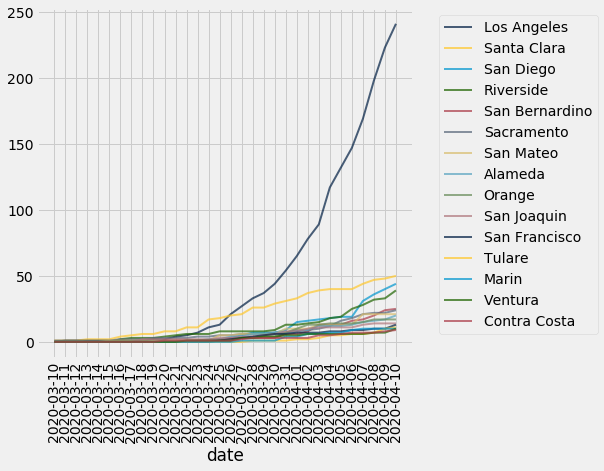

In [35]:
deaths.top(15).after('2020-03-10').oplot(height=6, width=6)
_ = plots.xticks(rotation=90)

In [36]:
prior_to(deaths.order_cols().trend(), 7)

date,Los Angeles,new Los Angeles,% newLos Angeles,rate Los Angeles,Santa Clara,new Santa Clara,% newSanta Clara,rate Santa Clara,San Diego,new San Diego,% newSan Diego,rate San Diego,Riverside,new Riverside,% newRiverside,rate Riverside,San Bernardino,new San Bernardino,% newSan Bernardino,rate San Bernardino,Sacramento,new Sacramento,% newSacramento,rate Sacramento,San Mateo,new San Mateo,% newSan Mateo,rate San Mateo,Alameda,new Alameda,% newAlameda,rate Alameda,Orange,new Orange,% newOrange,rate Orange,San Joaquin,new San Joaquin,% newSan Joaquin,rate San Joaquin,San Francisco,new San Francisco,% newSan Francisco,rate San Francisco,Tulare,new Tulare,% newTulare,rate Tulare,Marin,new Marin,% newMarin,rate Marin,Ventura,new Ventura,% newVentura,rate Ventura,Contra Costa,new Contra Costa,% newContra Costa,rate Contra Costa,Fresno,new Fresno,% newFresno,rate Fresno,Placer,new Placer,% newPlacer,rate Placer,Kern,new Kern,% newKern,rate Kern,Merced,new Merced,% newMerced,rate Merced,Monterey,new Monterey,% newMonterey,rate Monterey,Shasta,new Shasta,% newShasta,rate Shasta,Yolo,new Yolo,% newYolo,rate Yolo,Imperial,new Imperial,% newImperial,rate Imperial,Madera,new Madera,% newMadera,rate Madera,Napa,new Napa,% newNapa,rate Napa,San Benito,new San Benito,% newSan Benito,rate San Benito,Santa Barbara,new Santa Barbara,% newSanta Barbara,rate Santa Barbara,Solano,new Solano,% newSolano,rate Solano,Sonoma,new Sonoma,% newSonoma,rate Sonoma,Sutter,new Sutter,% newSutter,rate Sutter,Mono,new Mono,% newMono,rate Mono,Nevada,new Nevada,% newNevada,rate Nevada,San Luis Obispo,new San Luis Obispo,% newSan Luis Obispo,rate San Luis Obispo,Santa Cruz,new Santa Cruz,% newSanta Cruz,rate Santa Cruz,Stanislaus,new Stanislaus,% newStanislaus,rate Stanislaus,Yuba,new Yuba,% newYuba,rate Yuba,Alpine,new Alpine,% newAlpine,rate Alpine,Amador,new Amador,% newAmador,rate Amador,Butte,new Butte,% newButte,rate Butte,Calaveras,new Calaveras,% newCalaveras,rate Calaveras,Colusa,new Colusa,% newColusa,rate Colusa,Del Norte,new Del Norte,% newDel Norte,rate Del Norte,El Dorado,new El Dorado,% newEl Dorado,rate El Dorado,Glenn,new Glenn,% newGlenn,rate Glenn,Humboldt,new Humboldt,% newHumboldt,rate Humboldt,Inyo,new Inyo,% newInyo,rate Inyo,Kings,new Kings,% newKings,rate Kings,Lake,new Lake,% newLake,rate Lake,Mendocino,new Mendocino,% newMendocino,rate Mendocino,Plumas,new Plumas,% newPlumas,rate Plumas,Siskiyou,new Siskiyou,% newSiskiyou,rate Siskiyou,Tehama,new Tehama,% newTehama,rate Tehama,Tuolumne,new Tuolumne,% newTuolumne,rate Tuolumne,Unknown,new Unknown,% newUnknown,rate Unknown
2020-04-03,89,11,0.123596,1.14103,39,2,0.0512821,1.05405,17,1,0.0588235,1.0625,15,1,0.0666667,1.07143,13,5,0.384615,1.625,10,1,0.1,1.11111,13,3,0.230769,1.3,12,3,0.25,1.33333,13,0,0,1,11,1,0.0909091,1.1,7,0,0,1,3,1,0.333333,1.5,6,0,0,1,6,0,0,1,5,2,0.4,1.66667,1,1,1,inf,2,0,0,1,2,1,0.5,2,0,0,nan,nan,2,0,0,1,2,1,0.5,2,1,0,0,1,0,0,nan,nan,2,1,0.5,2,2,1,0.5,2,2,1,0.5,2,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,1,inf,0,0,nan,nan,1,0,0,1,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,-1,-inf,0,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,-1,-inf,0
2020-04-04,117,28,0.239316,1.31461,40,1,0.025,1.02564,18,1,0.0555556,1.05882,18,3,0.166667,1.2,13,0,0,1,12,2,0.166667,1.2,13,0,0,1,12,0,0,1,14,1,0.0714286,1.07692,11,0,0,1,8,1,0.125,1.14286,5,2,0.4,1.66667,7,1,0.142857,1.16667,6,0,0,1,5,0,0,1,1,0,0,1,2,0,0,1,2,0,0,1,0,0,nan,nan,2,0,0,1,2,0,0,1,1,0,0,1,0,0,nan,nan,2,0,0,1,2,0,0,1,2,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,1,inf,1,0,0,1,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan
2020-04-05,132,15,0.113636,1.12821,40,0,0,1,19,1,0.0526316,1.05556,1

## Detailed study of a county

These sections of the notebook allow diving into the picture for a particular particular. We start with the basic trends and then look at projects up to a couple weeks out. Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that. Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [37]:
def show_cty(county, prev = 7):
    prior_to(cases.extract(county).trend(), prev).show()
    prior_to(cases.extract(county).trend().extract([county, 'new']), 21).plot('date', width=7)
    _ = plots.xticks(rotation=45)
    prior_to(cases.extract(county).trend().extract(['rate']), 21).plot('date', width=7)
    _ = plots.xticks(rotation=45)

_ = interact(show_cty, county=counties, prev = (7, 21, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

<a id='sectionProj'></a>
## Projection of cases in one county

To look forward at what the story may be over the coming days, we project forward the recent growth rate. This may be pessimistic if measures are working and the rate is improving. But, the rate of change in the rate is low enough and the variability due to external factors high enough that any more sophisticated method seems dubious.

The vertical line shows where we are today.


In [38]:
def proj_cty(county, dist=14):
    proj(cases, county, 7, dist)
    
_ = interact(proj_cty, county=counties, dist = (7, 14, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

<a id='sectionProjDeath'></a>
## Projection of deaths in one county

Fortunately the mortality rates in most counties are still low enough that the projections are not very meaningful.  Let's hope things stay that way

In [39]:
def proj_cty_deaths(county, dist=14):
    proj(deaths, county, 7, dist)

_ = interact(proj_cty_deaths, county=counties, dist = (7, 14, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

## Are the projections changing with mitigation measures?

We are seeing reductions in growth rates as communities adopt shelter in place and other isolation measures.  How does out prediction today for two weeks out differ from what we would have made yesterday for 15 days out?  

This graph shows the project based on the most current data and compares it to the projection based on
`prev` days ago.  If measures are succeeding, we should see improvements relative to `-prev`.  The distance of projection is adjustable.

In [40]:
def proj2_cty(county, prev=2, dist=14):
    proj2(cases, county, prev, dist)
    
_ = interact(proj2_cty, county=counties, prev=(0,7,1), dist=(3, 14, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

In [41]:
def proj2_cty_deaths(county, prev=2, dist=14):
    proj2(deaths, county, prev, dist)
    
_ = interact(proj2_cty_deaths, county=counties, prev=(0,7,1), dist=(3, 14, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving. This is probably premature for counties, unlike states, because the daily numbers are bouncing around due to the relatively small numbers.  Unfortunately, that situation is unlikely to remain.

In [42]:
def get_rates(ts):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if 'rate' in x])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

In [43]:
prior_to(get_rates(cases), 7)

date,Alameda,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,Humboldt,Imperial,Inyo,Kern,Kings,Lake,Los Angeles,Madera,Marin,Mendocino,Merced,Mono,Monterey,Napa,Nevada,Orange,Placer,Plumas,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Francisco,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Tulare,Tuolumne,Unknown,Ventura,Yolo,Yuba
2020-04-03,1.11271,1,1,1.1,1.33333,2,1.11232,1,1.15789,1.06383,1,1.08108,1.1,1,1.28387,1,nan,1.1288,1,1.11017,1,1,1.05556,1.10417,1.10526,1.03333,1.08384,1.07778,2,1.29412,1.14412,1,1.16118,1.15114,1.11111,1.03933,1.04494,1.07285,1.09353,1.0736,1.03509,1.57143,1,1.18182,1.05263,1.16,1.14286,inf,1.09459,1,nan,1.0678,1.17857,1.125
2020-04-04,1,1,1,1,1,1,1.14984,2,1,1.03,1,1.1,1,1,1.03015,1,nan,1.15572,1.07143,1.0458,1,1,1,1.16981,1,1,1.10549,1,1.5,1.04232,1.05656,1,1,1.08723,1.058,1.03243,1,1.107,1.10526,1.04936,1.05085,1.54545,1,1,1.05,1.12069,1,1,1.32099,1,nan,1.07407,1,1
2020-04-05,1.26509,1,1,1,1,1,1.09348,1,1,1.04854,1,1,1.03636,1.1,1.09756,1,nan,1.12564,1,1.0292,1,1.8125,1,1,1,1,1.06107,1.06186,1,1.2015,1.07299,1,1.05382,1.09677,1.0794,1.06283,1.02151,1.0316,1.03571,1.05139,1.1129,1.17647,1,1,1.01905,1.09231,1,1,1.08411,1,nan,1.08867,1.12121,1.11111
2020-04-06,1.03748,2,1,1.09091,1.25,1.5,1.08031,1,1.13636,1.14815,1,1.11364,1.19298,1,1.09333,1,inf,1.07071,0.933333,1.01418,1,1,1,1.01613,1.04762,1.03226,1.05755,1.02913,1,1.18398,1.04535,1.30435,1.42473,1.05882,1.02627,1.04433,1,1.04324,1.10345,1.01408,1.02899,1.05,1.33333,1.19231,1.07477,1.14085,1.125,1,1.16379,1,nan,1.02262,1.35135,1.1
2020-04-07,1.07553,1,1,1.08333,1,1,1.05995,1,1.12,1.17742,1,1.02041,1.07353,1,1.08537,1,1,1.08648,1.07143,1.03497,1,1.17241,1,1.01587,1.09091,1.0625,1.05556,1.08491,1,1.074,1.13666,1.03333,1.03208,1.03561,1.06143,1.05189,1.04211,1.01727,1.13542,1.04984,1.07042,1.09524,1,1.11828,1.04348,1.11111,1.05556,1,1.16296,1,nan,1.07522,1.12,1.18182
2020-04-08,1.06107,1,1,1,1,1,1.04525,1,1.03571,1.06849,1,1,1.0274,1,1.1573,1.4,1.5,1.08973,1,1.00676,1,1.17647,1.05263,1.07812,1.08333,1,1.0913,1.01739,1,1.16043,1.10496,1.06452,1.17185,1.05227,1.09164,1.06278,1.0303,1.04754,1.04587,1.07393,1,1.04348,1,1.125,1.025,1.05556,1.05263,1,1.07006,1,nan,1.0823,1.19643,1.15385
2020-04-09,1.05612,1,3,1,1.6,1,1.04762,1,1.03448,1.10897,1,1,1.05333,1,1.06796,1,1,1.05644,1,1.03356,1,1,1,1.02899,1.11538,1,1.06201,1.02564,1,1.08567,1.05699,1.0303,1.13729,1.06405,1.07069,1.03376,1.01961,1.02593,1.06579,1.04493,1.05263,1,1,1.02564,1.10569,1.08421,1.1,1,1.1131,1,nan,1.04183,1.0597,1
2020-04-10,1.0436,1,1,1.07692,1,1,1.05579,1,1.06667,1.10405,1.5,1,1,1.09091,1.1,1.28571,1.33333,1.05971,1.06667,1,1,1.475,1.05,1.11268,1.13793,1,1.05468,1.025,1.33333,1.05469,1.06536,1.02941,1.11111,1.04177,1.10041,1.04898,1.02885,1.0079,1.06996,1.02913,1,1,1.25,1.05,1.06618,1.12621,1,1,1.08556,1,nan,1.08759,1.05634,1


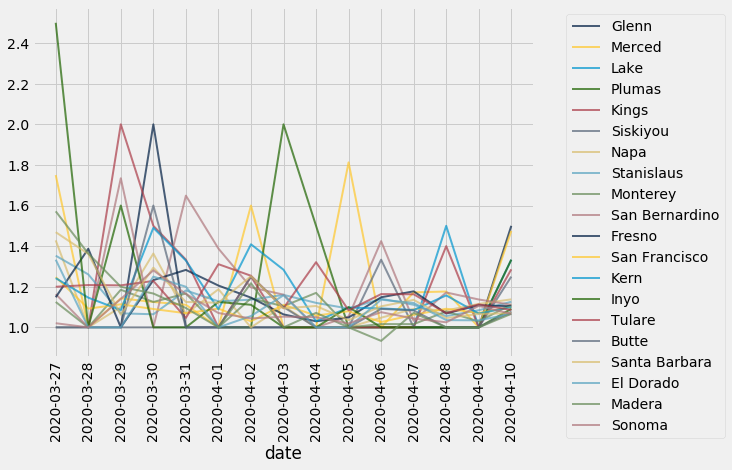

In [44]:
prior_to(get_rates(cases), 14).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

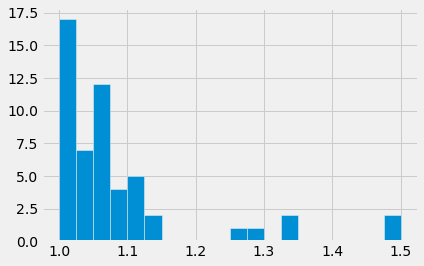

In [45]:
_ = plots.hist([x for x in get_rates(cases).take[-1].row(0)[1:] if np.isfinite(x)], bins=20)

In [46]:
def best_rate(ts, n):
    rates = prior_to(get_rates(ts), 7).order_cols()
    best = rates.labels[-n:]
    return rates.extract(best)

In [47]:
best_rate(cases, 12)

date,Marin,Mendocino,Nevada,Santa Cruz,Shasta,Sutter,Tehama,Tuolumne,Unknown,Ventura,Yolo,Yuba
2020-04-03,1.11017,1,1.03333,1.03509,1.57143,1.14286,inf,1,nan,1.0678,1.17857,1.125
2020-04-04,1.0458,1,1,1.05085,1.54545,1,1,1,nan,1.07407,1,1
2020-04-05,1.0292,1,1,1.1129,1.17647,1,1,1,nan,1.08867,1.12121,1.11111
2020-04-06,1.01418,1,1.03226,1.02899,1.05,1.125,1,1,nan,1.02262,1.35135,1.1
2020-04-07,1.03497,1,1.0625,1.07042,1.09524,1.05556,1,1,nan,1.07522,1.12,1.18182
2020-04-08,1.00676,1,1,1,1.04348,1.05263,1,1,nan,1.0823,1.19643,1.15385
2020-04-09,1.03356,1,1,1.05263,1,1.1,1,1,nan,1.04183,1.0597,1
2020-04-10,1,1,1,1,1,1,1,1,nan,1.08759,1.05634,1


In [48]:
def get_new(trend, region):
    return trend['new ' + region][-1]

def get_rate(trend, region):
    return trend['rate ' + region][-1]

def get_val(trend, region):
    return trend[region][-1]

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'current', [get_val(trend, r) for r in regions],
        'new',  [get_new(trend, r) for r in regions],
        'rate', [get_rate(trend, r) for r in regions]
    )
    return smry

In [49]:
case_sum = summary(cases, 'county', counties)

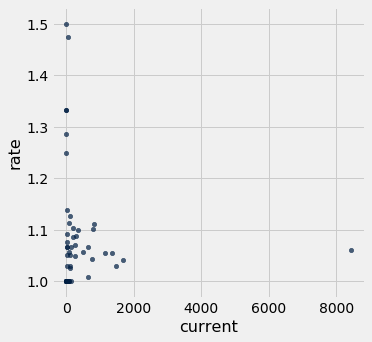

In [50]:
case_sum.scatter('current', 'rate')